# Знакомство с RL
- Разберем основные модули: агент, среда
- Определим стратегию
- Зададим критерий для оптимизации поведения
- Разберем вознаграждение и 
- Познакомимся с фреймворками обучения
NOTE: для удобства загружайте тетрадку в Colab

In [ ]:
# @title Установка зависимостей
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install swig
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license,box2d]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
from IPython.display import clear_output
from time import sleep
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

## 1. Взаимодействие агент-среда <a name = 'envage'></a>

В обучении с подкреплением рассматривается взаимодейтвие между агентом (*agent*) и средой (*environment*):

Агент получает наблюдения (*observation*) и вознаграждения (*reward*) из среды, и выполняет действия (*action*) в среде. Действия вызывают изменения в среде согласно её внутренним законам, что влияет на наблюдения и вознаграждения отправляемые агенту.

<center>
<img src='https://gymnasium.farama.org/_images/AE_loop.png' width="300">
</center>


<img src=https://gymnasium.farama.org/_images/lunar_lander.gif caption="lunar lander" width="150" height="50"><img src=https://gymnasium.farama.org/_images/mountain_car.gif caption="mountain car" width="150" height="50">
<img src=https://gymnasium.farama.org/_images/cliff_walking.gif caption="cliff walking" width="300" height="50">
<img src=https://ale.farama.org/_images/montezuma_revenge.gif caption="montezuma revenge" width="150" height="100">
<img src=https://github.com/danijar/crafter/raw/main/media/video.gif caption="crafter" width="150" height="100">
<img src=https://camo.githubusercontent.com/6df2ca438d8fe8aa7a132b859315147818c54af608f8609320c3c20e938acf48/68747470733a2f2f6d656469612e67697068792e636f6d2f6d656469612f344e78376759694d394e44724d724d616f372f67697068792e676966 caption="malmo minecraft" width="150" height="100">
<img src=https://images.ctfassets.net/kftzwdyauwt9/e0c0947f-1a44-4528-4a41450a9f0a/2d0e85871d58d02dbe01b2469d693d4a/table-03.gif caption="roboschool" width="150" height="100">
<img src=https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/02/mdp.png caption="Марковский процесс принятия решений" width="150" height="100">
<img src=https://minigrid.farama.org/_images/DoorKeyEnv.gif caption="minigrid" width="120" height="120">


## 2. Среда

Описывает задачу. Для игры в шахматы нужен симулятор шахмат, для обучения робтов — симулятор физики, для игры — соответсвтующие движки. Особенность их в том, что они являются черным ящиком: ничего не известно о внутреннем устройстве.

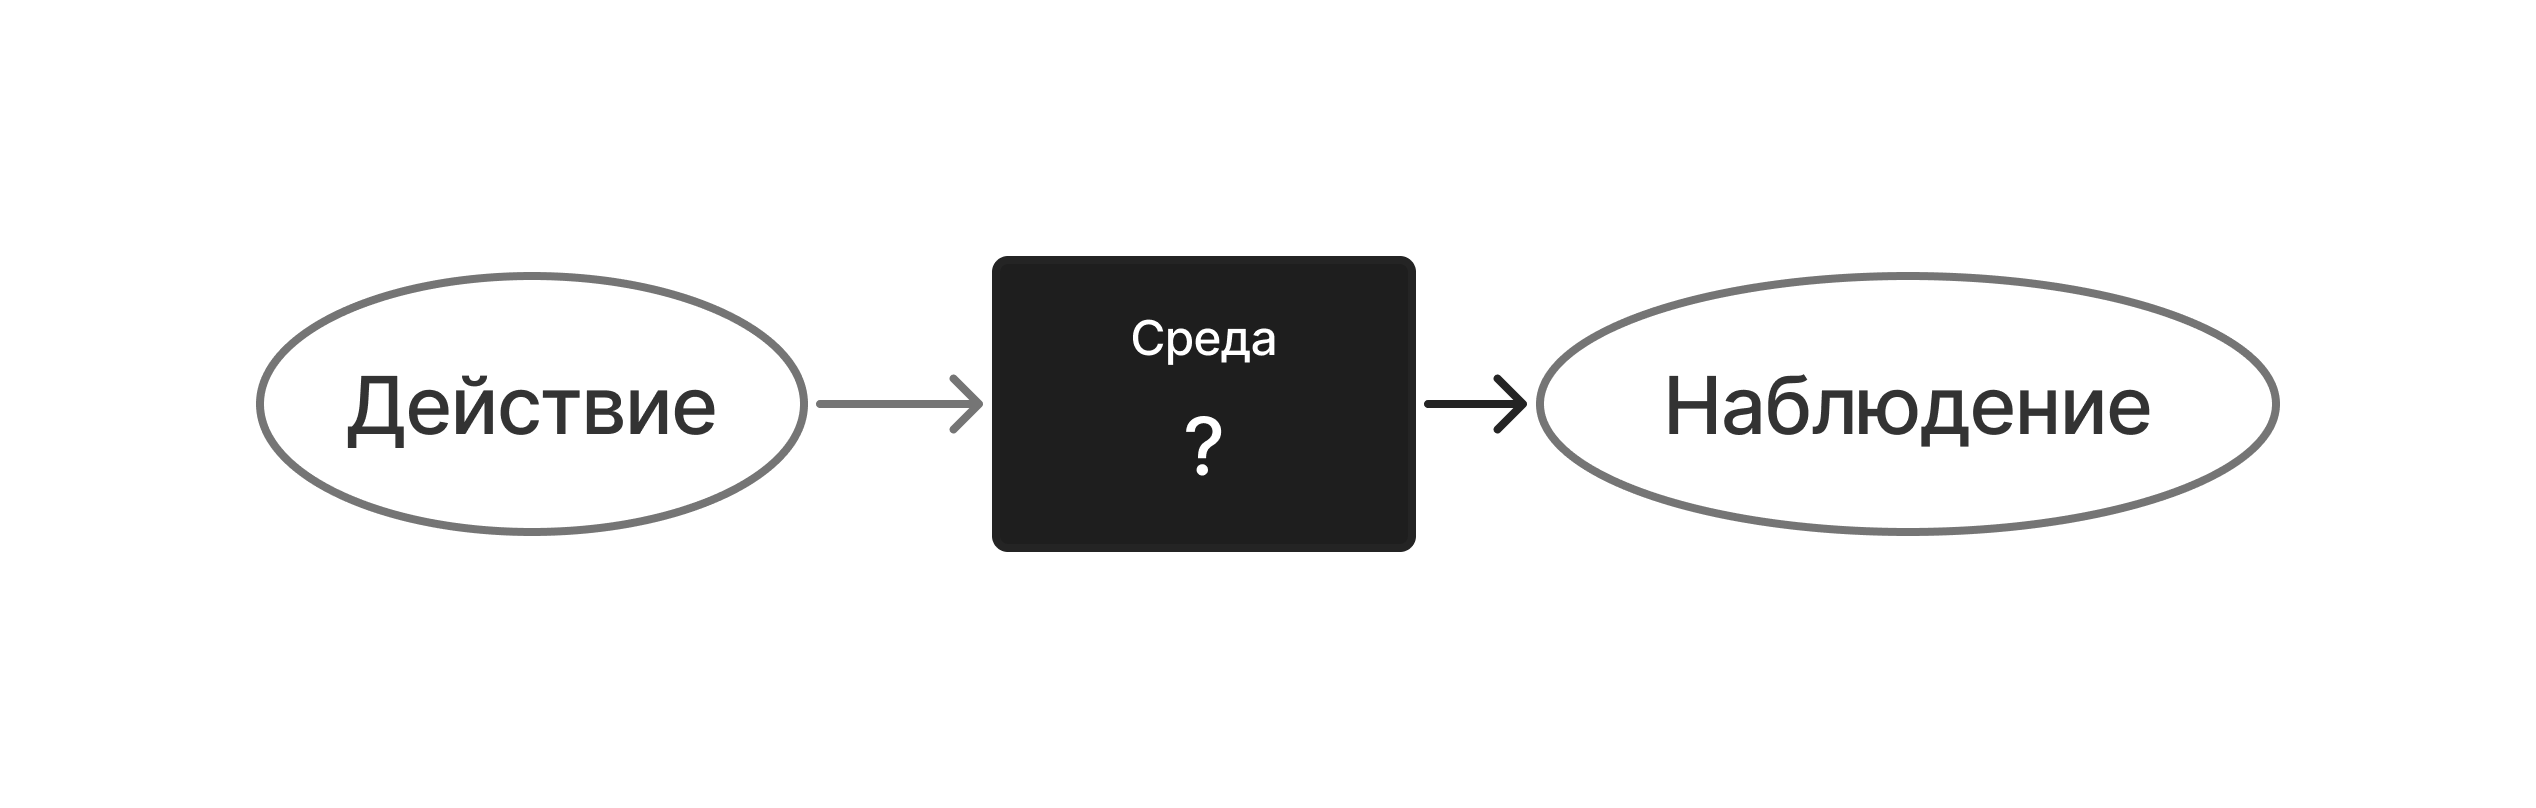

### Попробуйте привести примеры сред. Что можно назвать средой?

## Фреймворки со средами
Классика это OpenAI [Gym](https://gym.openai.com), который на текущий момент уже устарел. И сейчас базовый набор rlщика это [Gymnasium](https://gymnasium.farama.org/) от [Farama Foundation](https://farama.org/projects)

In [ ]:
import gymnasium as gym

# Создаем среду
env = gym.make("MountainCar-v0")

# Инициализируем среду
obs, info = env.reset()
print(f"observation: {obs}")

# Выполняем действие в среде
next_obs, r, terminated, truncated, info = env.step(0)
print(f"next_observation: {next_obs} , r: {r}, terminated: {terminated}, truncated: {truncated}, info: {info}")

# Закрываем среду
env.close()

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()
plt.close()

**Какой функционал нам доступен?**



### Основные методы:

* ``reset()`` $-$ инициализация среды, возвращает первое наблюдение (состояние) и доп информацию.  
* ``step(a)`` $-$ выполнить в среде действие $\mathbf{a}$ и получить кортеж: $\mathbf{\langle o_{t+1}, r_t, terminated, truncated, info \rangle}$, где $\mathbf{o_{t+1}}$ - следующее наблюдение, $\mathbf{r_t}$ - вознаграждение, $\mathbf{terminated}$ - флаг завершения эпизода, $\mathbf{truncated}$ — флаг завершения эпизода по step-лимиту, $\mathbf{info}$ - дополнительная информация

### Дополнительные методы:
* ``render()`` $-$ визуализация текущего состояния среды
* ``close()`` $-$ закрывает окружение


### Свойства среды:
* ``env.observation_space`` $-$ информация о пространстве наблюдений
* ``env.action_space`` $-$ информация о пространстве действий


In [ ]:
while True:
    env.step(1)
    plt.imshow(env.render())
    plt.show()
    plt.close()
    sleep(0.5)
    clear_output()

## 3. Агент

Что такое агент?

Приведите пример "необычных" агента и среды


<img src=https://gymnasium.farama.org/_images/lunar_lander.gif caption="lunar lander" width="150" height="50"><img src=https://gymnasium.farama.org/_images/mountain_car.gif caption="mountain car" width="150" height="50">
<img src=https://gymnasium.farama.org/_images/cliff_walking.gif caption="cliff walking" width="300" height="50">
<img src=https://ale.farama.org/_images/montezuma_revenge.gif caption="montezuma revenge" width="150" height="100">
<img src=https://github.com/danijar/crafter/raw/main/media/video.gif caption="crafter" width="150" height="100">
<img src=https://camo.githubusercontent.com/6df2ca438d8fe8aa7a132b859315147818c54af608f8609320c3c20e938acf48/68747470733a2f2f6d656469612e67697068792e636f6d2f6d656469612f344e78376759694d394e44724d724d616f372f67697068792e676966 caption="malmo minecraft" width="150" height="100">
<img src=https://images.ctfassets.net/kftzwdyauwt9/e0c0947f-1a44-4528-4a41450a9f0a/2d0e85871d58d02dbe01b2469d693d4a/table-03.gif caption="roboschool" width="150" height="100">
<img src=https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/02/mdp.png caption="Марковский процесс принятия решений" width="150" height="100">
<img src=https://minigrid.farama.org/_images/DoorKeyEnv.gif caption="minigrid" width="120" height="120">


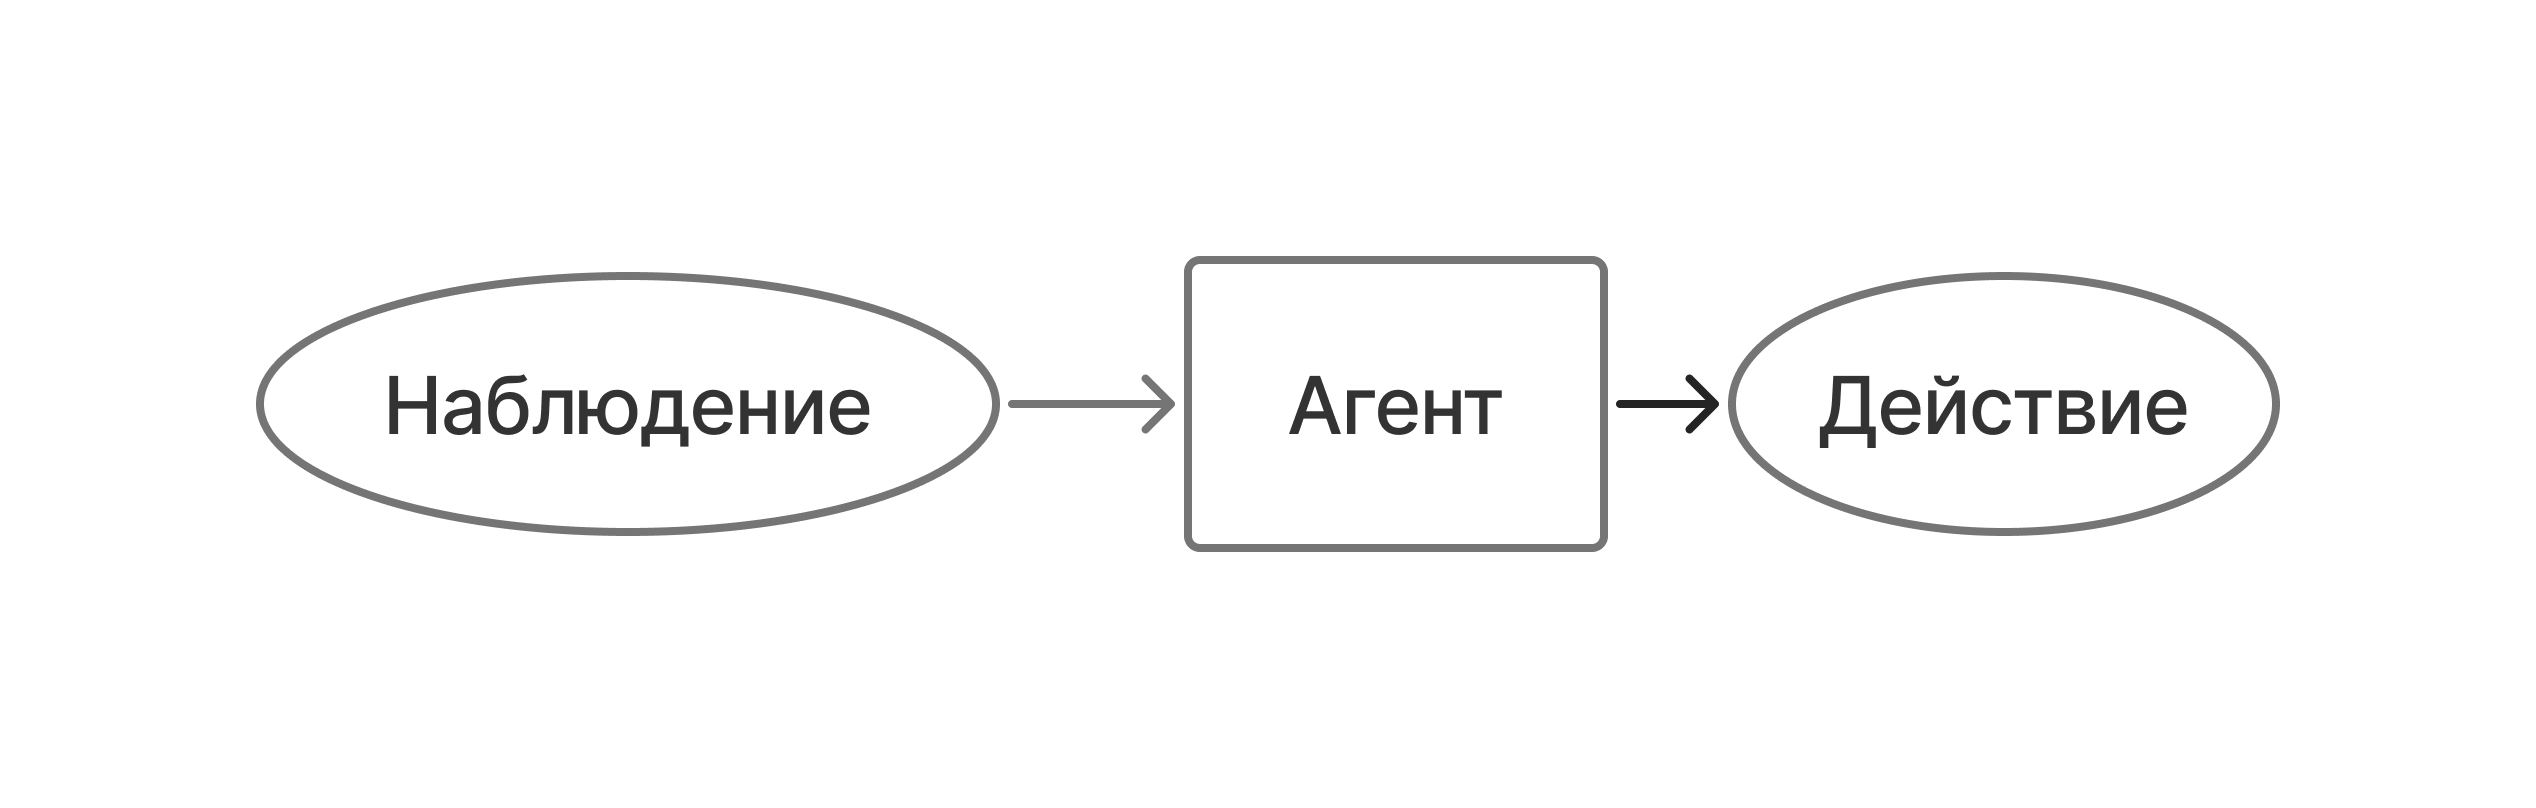

### Пример со случайной стратегией:

Для выбора действия используется ``env.action_space.sample()``

In [ ]:
from gymnasium.wrappers import RecordVideo

# создаем среду с ограничением на число шагов в среде
env = gym.make("LunarLander-v3", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False

while not done:
    # выполняем действие, получаем s, r, done, info
    s, r, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated

env.close()
show_video()

### Задание
В среде ``MountainCar-v0`` мы хотим, чтобы машина достигла флага. Давайте решим эту задачу, не используя обучение с подкреплением. Модифицируйте код функции ``act`` ниже для выполнения этого задания. Функция получает на вход состояние среды и должна вернуть действие.

In [ ]:
def act(s):
    # список возможных действий
    left, stop, right = 0, 1, 2

    # позиция и скорость
    position, velocity = s
    # пример: можем попробовать всегда ехать вправо
    # action = right
    ####### Здесь ваш код ########
    if velocity > 0:
        action = right
    else:
        action = left
    ##############################
    return action

In [ ]:
env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=250)
# добавляем визуализацию
env = RecordVideo(env, "./video")

# проводим инициализацию и запоминаем начальное состояние
s, _ = env.reset()
done = False

while not done:
    # выполняем действие, получаем s, r, done, info
    s, r, terminated, truncated, _ = env.step(act(s))
    done = terminated or truncated

if s[0] > 0.47:
    print("Принято!")
else:
    print("""Исправьте функцию выбора действия!""")


env.close()
show_video()

## 4. Вознаграждение
Как задать поведение агента?

Что необходимо учитывать?

### **Reward hacking**
https://openai.com/index/faulty-reward-functions/

### Return, expected return

**Отдача**: $G(s_t) = \sum_{i=t}^T r_i$

Обычно также вводят параметр $\gamma \in [0, 1]$, дисконтирующий будущие вознаграждения.

**NOTE!!!** отдача может меняться от запуска к запуску благодаря вероятностным процессам, нас интересует отдача в среднем — ожидаемая отдача:

$$\hat{G}(s_t) = \mathbb{E} \left[ \sum_{i=t}^T \gamma^{i-t} r_i \right]$$

**RL агент максимизирует ожидаемую отдачу.**

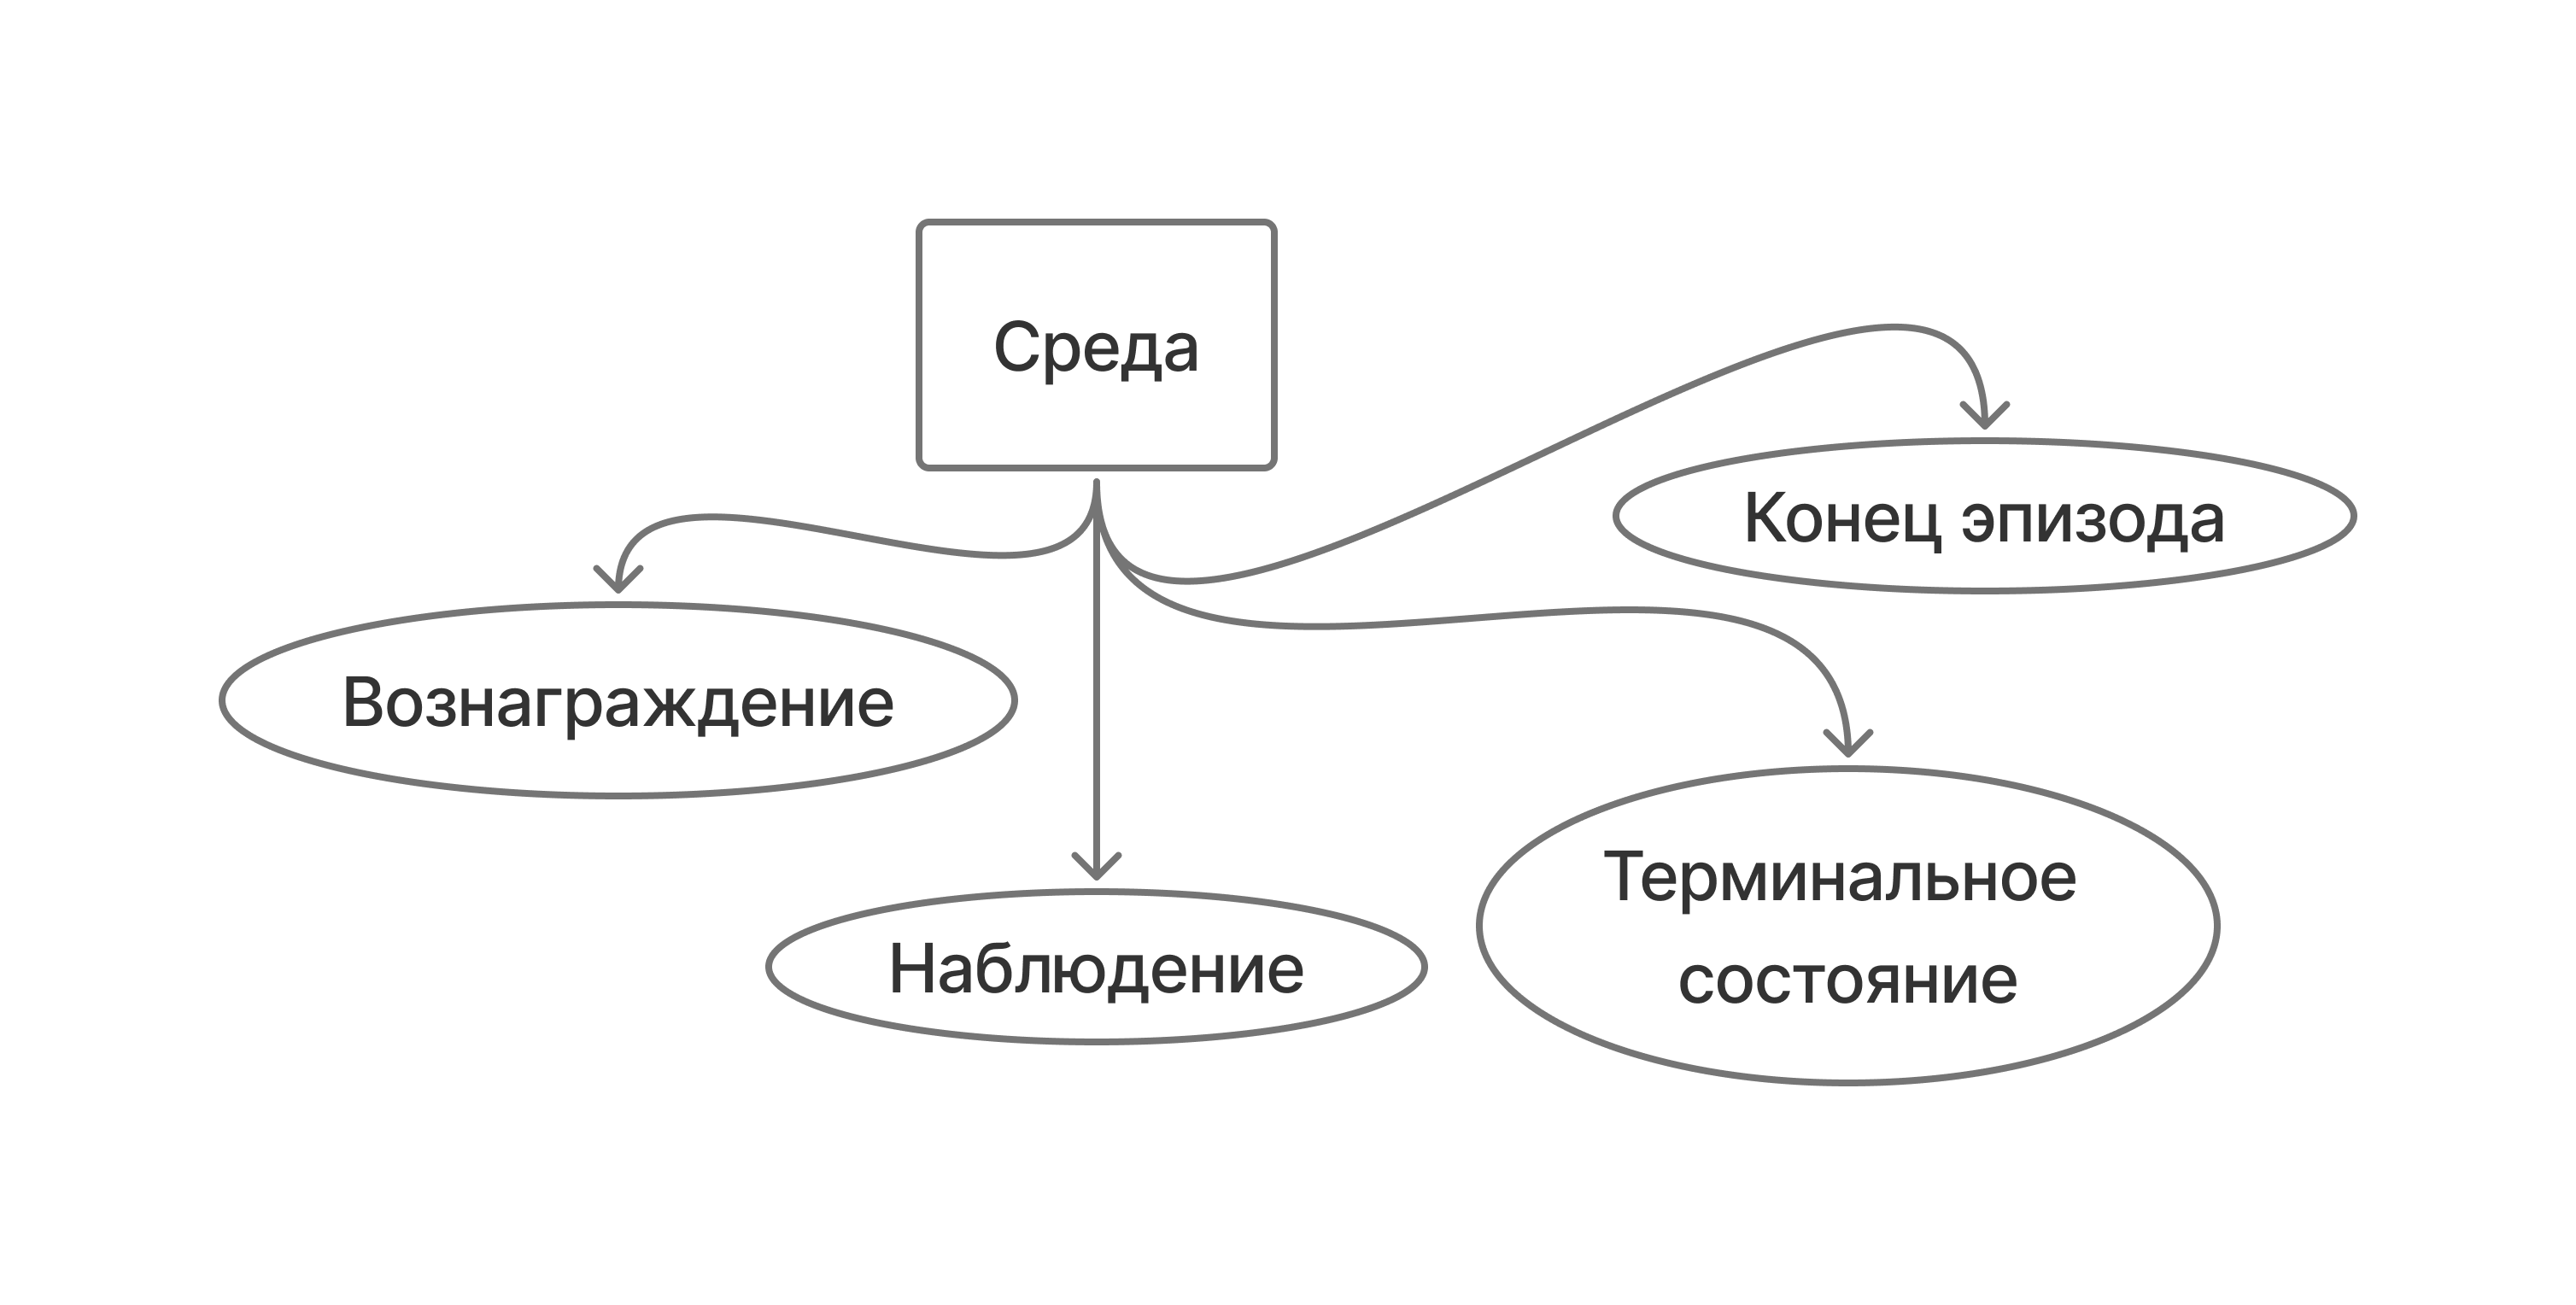

## 5. Знакомство с бенчмарками

- [CleanRL](https://docs.cleanrl.dev/)
    
    Реализации основных алгоритмов в одном скрипте, легко прослеживается логика алгоритма.
- [Stable Baselines](https://github.com/DLR-RM/stable-baselines3)

    Широкий выбор инструментов и алгоритмов, однако преобладает высокая модульность: тяжело разобраться с отдельным алгоритмом, необходимо изучать весь фреймворк.
- [PureJaxRL](https://github.com/luchris429/purejaxrl)

    Близко к CleanRl однако использует Jax --- для фанатов Jax.